Team Members:\
Aryaman Gokarn(506303588)\
Mugdha Bhagwat(606297799)\
Tania Rajabally(806153219)


# **Inverse Reinforcement learning (IRL)**

### QUESTION 10

Question 10: (10 points) Express c, x, D, b in terms of R, Pa, Pa1
, ti
, u, λ and Rmax

> IRL is the task of extracting the reward function from the optimal policy, particularly when the reward function is not known a priori. The goal of IRL is to find the set of possible reward functions such that is an optimal policy, given state space, action space, optimal deterministic policy and state transition matrix. In IRL, the agent observes an expert’s behavior and learn’s the expert’s reward function to generate the optimal policy. An expert’s optimal policy can be used to extract the reward function, thereby computing the optimal policy of the agent. We prefer learning the reward function rather than the policy directly because the reward function provides a robust, succinct and transferable definition of the task at hand. The LP formulation of IRL is given by:

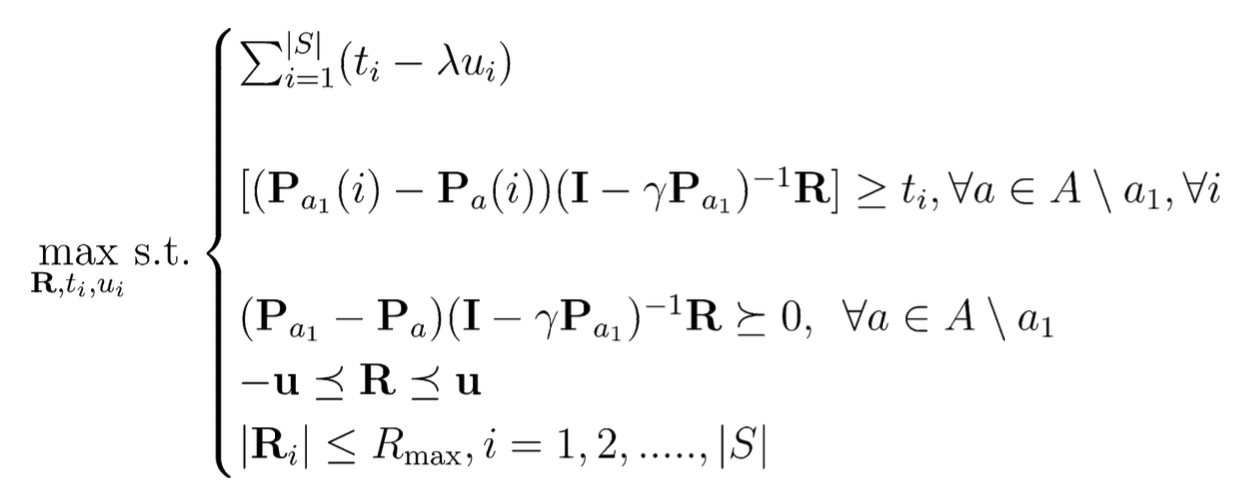

For simplicity, we want to recast the LP formulation as follows:

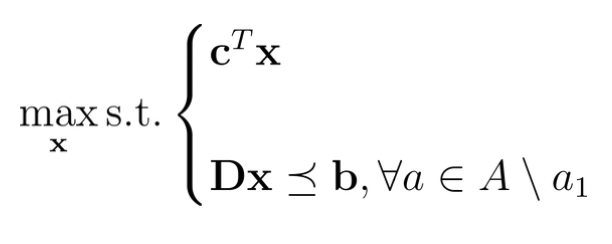

Here, we consider the equation of the form Dx≤b. The identity matrix has been denoted by I and the dimensions of each matrix has been mentioned as their subscript. After recasting, we get the below matrix:

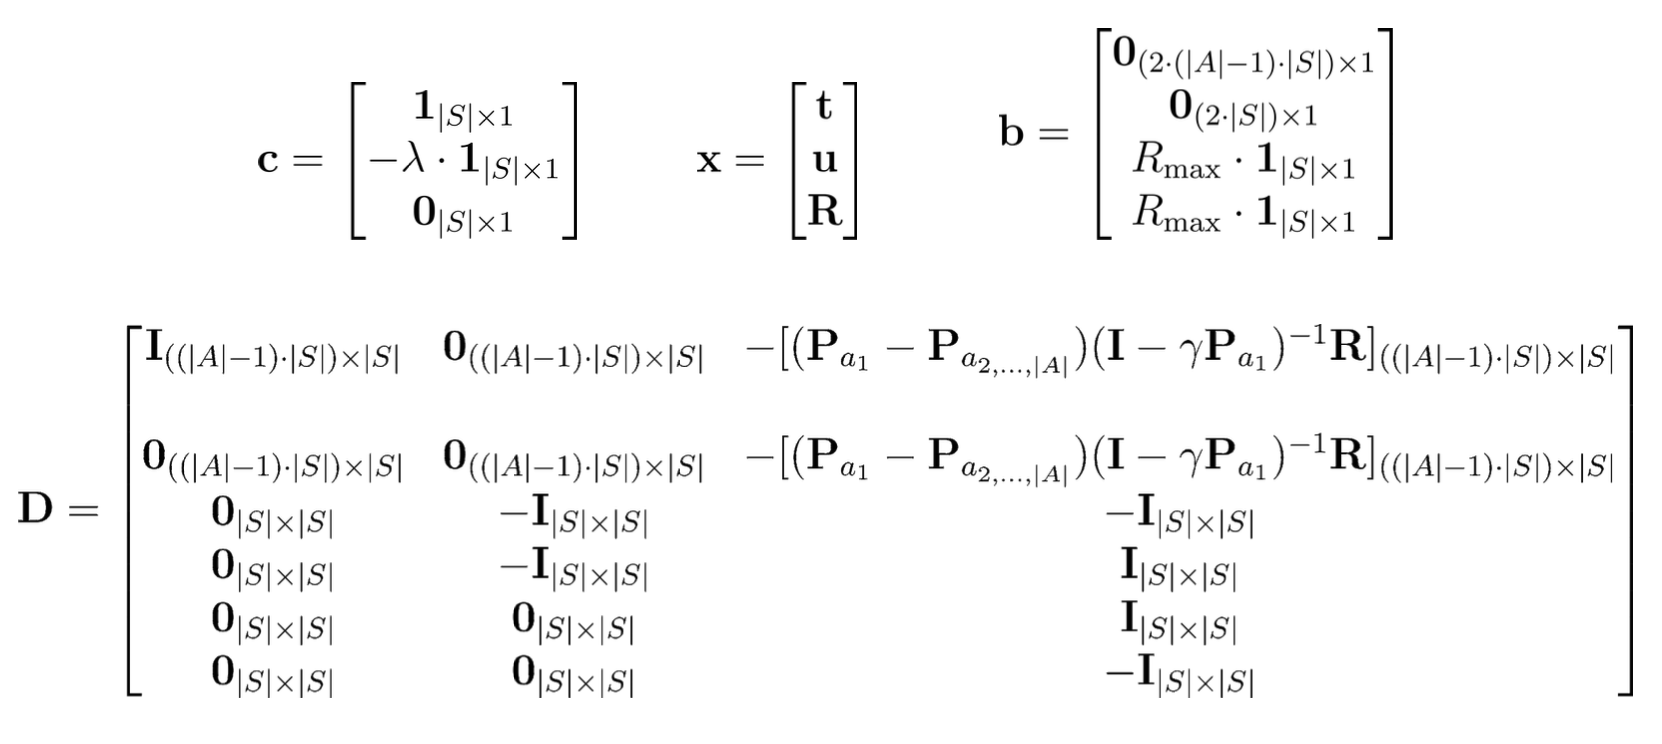

In our case |A|=4 and |S|=100.


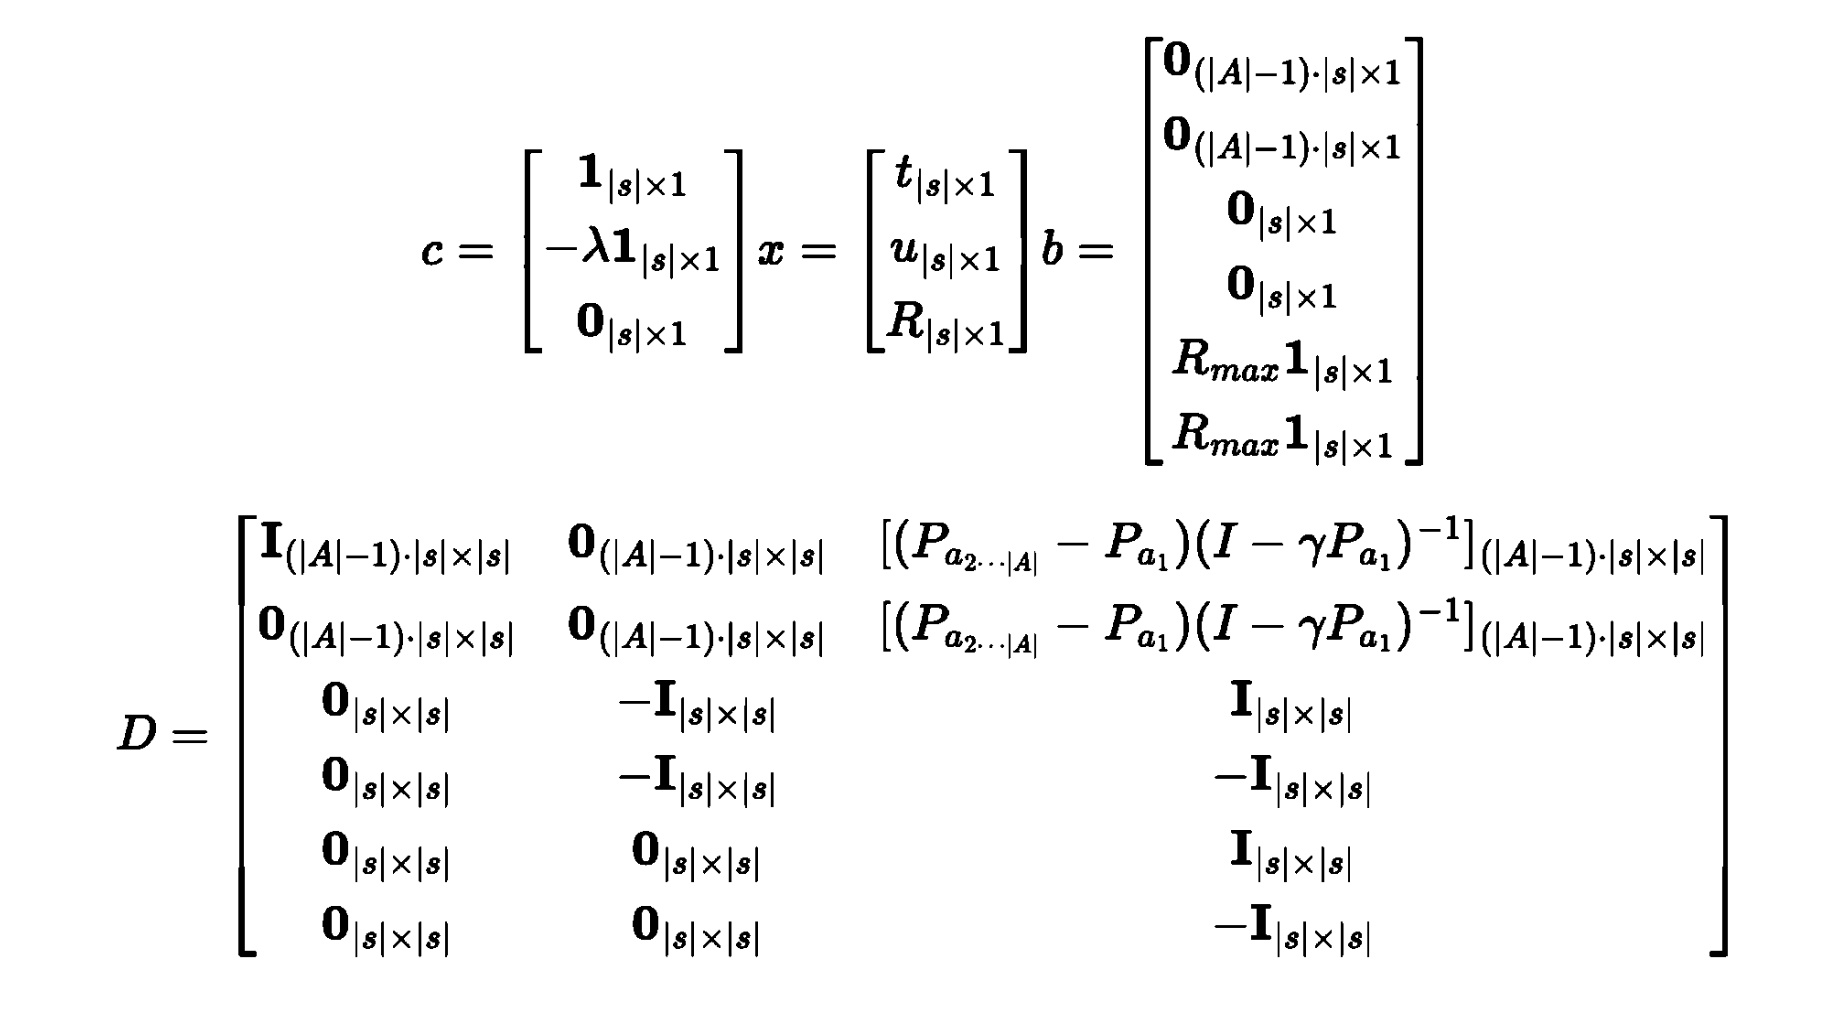




### QUESTION 11

In [2]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
import pandas as pd
from cvxopt import matrix, solvers
from tqdm import tqdm

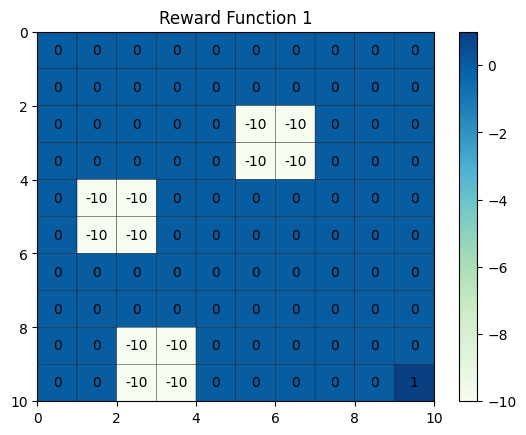

In [3]:
# Reward function 1
reward_function1 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, -10, -10, 0, 0, 0],
                   [0, 0, 0, 0, 0, -10, -10, 0, 0, 0],
                   [0, -10, -10, 0, 0, 0, 0, 0, 0, 0],
                   [0, -10, -10, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, -10, -10, 0, 0, 0, 0, 0, 0],
                   [0, 0, -10, -10, 0, 0, 0, 0, 0, 1]])

plt.pcolor(reward_function1, cmap='GnBu', edgecolors='black')

plt.title("Reward Function 1")
for (j,i),label in np.ndenumerate(reward_function1):
  plt.text(i+0.5, j+0.5, label, ha='center', va='center')

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

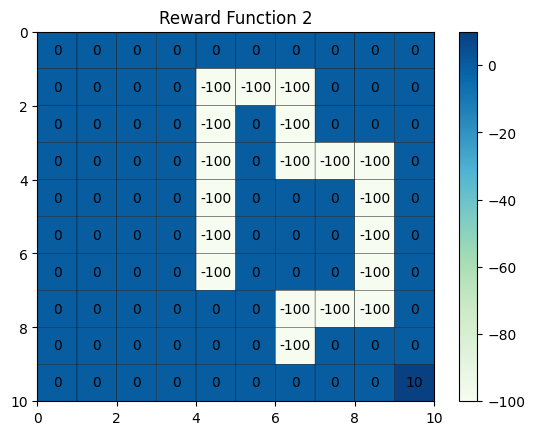

In [4]:
# Reward function 2
reward_function2 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, -100, -100, -100, 0, 0, 0],
                   [0, 0, 0, 0, -100, 0, -100, 0, 0, 0],
                   [0, 0, 0, 0, -100, 0, -100, -100, -100, 0],
                   [0, 0, 0, 0, -100, 0, 0, 0, -100, 0],
                   [0, 0, 0, 0, -100, 0, 0, 0, -100, 0],
                   [0, 0, 0, 0, -100, 0, 0, 0, -100, 0],
                   [0, 0, 0, 0, 0, 0, -100, -100, -100, 0],
                   [0, 0, 0, 0, 0, 0, -100, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 10]])

plt.pcolor(reward_function2, cmap='GnBu', edgecolors='black')

plt.title("Reward Function 2")
for (j,i),label in np.ndenumerate(reward_function2):
  plt.text(i+0.5, j+0.5, label, ha='center', va='center')

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [5]:
# Get all neighbours of the given state
def get_nbr(state, state_space):
  row, col = state_space[state]
  # get the neighbor coordinate
  r_nbr = (row, col+1) if col+1 <= 9 else (row, col)
  l_nbr = (row, col-1) if col-1 >= 0 else (row, col)
  u_nbr = (row-1, col) if row-1 >= 0 else (row, col)
  d_nbr = (row+1, col) if row+1 <= 9 else (row, col)

  # return neighbor state - order ["right", "left", "up", "down"]
  return (r_nbr[0]+r_nbr[1]*10, l_nbr[0]+l_nbr[1]*10,
          u_nbr[0]+u_nbr[1]*10, d_nbr[0]+d_nbr[1]*10)

In [6]:
# Transition probabilities matrix for each action
def get_tp(w, actions, state_space):
  # init
  tp = dict()
  for act in actions:
    tp[act] = np.zeros((100, 100))

  # iterate through each state
  for i in range(num_states):
    nbrs = get_nbr(i, state_space)
    for a in range(len(actions)):
      for n in range(len(nbrs)):
        tp[actions[a]][i, nbrs[n]] += w/4
        if a == n:
          tp[actions[a]][i, nbrs[n]] += 1 - w

  return tp

In [7]:
# create a state_space for mapping of states numbering and coordinate
num_states = 100
state_space = dict()
for i in range(num_states):
  row = i % 10
  col = i // 10
  state_space[i] = (row, col)

# action set
num_acts = 4
act_sets = np.array(["right", "left", "up", "down"])

# reward function (#1) in 1D
rwd = reward_function1.flatten("F")

# discount factor
gamma = 0.8

# transition probabilities matrix with probability w
w = 0.1
tp = get_tp(w, act_sets, state_space)

In [8]:
# Optimal state-value function
def optimal_state_value_function(tp, rwd, state_space, actions, gamma, epsilon):
  # init
  Vs = np.zeros(len(state_space))
  delta = np.inf
  num_steps = 0
  old_Vs = np.copy(Vs)

  while delta > epsilon:
    delta = 0
    for i in range(len(state_space)):
      Vs[i] = max([np.sum(tp[act][i]*(rwd + gamma*old_Vs)) for act in actions])
      delta = max(delta, abs(old_Vs[i] - Vs[i]))
    old_Vs = np.copy(Vs)
    num_steps += 1

  return Vs, num_steps

In [12]:
# Optimal state-value function
def optimal_policy_function(tp, rwd, state_space, actions, gamma, epsilon):
  # init
  Vs = np.zeros(len(state_space))
  delta = np.inf
  num_steps = 0
  old_Vs = np.copy(Vs)
  policy = np.zeros(100)

  while delta > epsilon:
    delta = 0
    for i in range(len(state_space)):
      Vs[i] = max([np.sum(tp[act][i]*(rwd + gamma*old_Vs)) for act in actions])
      delta = max(delta, abs(old_Vs[i] - Vs[i]))
    old_Vs = np.copy(Vs)
    num_steps += 1

  for i in range(len(state_space)):
    policy[i] = np.argmax([np.sum(tp[act][i]*(rwd + gamma*Vs)) for act in actions])

  return Vs, num_steps, policy

In [11]:
# Plot the arrows
def plot_arrow(action_matrix):

    fig, ax = plt.subplots()
    num_rows = len(action_matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = action_matrix[i][j]
            arrow = ''
            if(c == 0):
                arrow = u'→'
            elif(c == 1):
                arrow = u'←'
            elif(c == 2):
                arrow = u'↑'
            else:
                arrow = u'↓'

            ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()

In [9]:
def irl(P_exp, tp, R_max, state_space, act_sets, gamma, lambda_):
  # parameter
  num_states = len(state_space)
  num_acts = len(act_sets)

  # init
  I = np.identity(num_states)
  Z = np.zeros((num_states, num_states))
  P_a1 = np.zeros((num_states, num_states))
  P_as = np.zeros((3, num_states, num_states))
  D = np.array([])

  # get P_a1 and P_as
  for i in range(len(P_exp)):
    policy_direction = act_sets[int(P_exp[i])]
    P_a1[i, :] = tp[policy_direction][i]
    other_actions = np.setdiff1d(range(num_acts), P_exp[i])
    for j, a in enumerate(other_actions):
      P_as[j, i, :] = tp[act_sets[a]][i]

  # get c, D, b matrices
  for i in range(num_acts-1):
    P_a = P_as[i]
    temp = np.hstack((I, Z, np.matmul(P_a - P_a1, np.linalg.inv(I - gamma*P_a1))))
    temp = np.vstack((temp,
                      np.hstack((Z, Z, np.matmul(P_a - P_a1, np.linalg.inv(I - gamma*P_a1))))))
    if D.shape[0] == 0:
      D = temp
    else:
      D = np.vstack((temp, D))

  D = np.vstack((D,
                 np.hstack((Z, -I, I)),
                 np.hstack((Z, -I, -I)),
                 np.hstack((Z, Z, I)),
                 np.hstack((Z, Z, -I))))

  b = np.vstack((np.zeros(((num_acts-1)*num_states, 1)),
                 np.zeros(((num_acts-1)*num_states, 1)),
                 np.zeros((num_states, 1)),
                 np.zeros((num_states, 1)),
                 R_max*np.ones((num_states, 1)),
                 R_max*np.ones((num_states, 1))))

  c = np.vstack((np.ones((num_states, 1)),
                 -lambda_*np.ones((num_states, 1)),
                 np.zeros((num_states, 1))))

  # solve x and get predicted R
  solvers.options['show_progress']=False
  sol = solvers.lp(-matrix(c), matrix(D), matrix(b))
  R = np.array(sol['x'][-100:]).squeeze()

  return R

In [10]:
def accuracy(exp_pol,ag_pol):
  num_states = len(exp_pol)
  count = 0.0
  for i in range(num_states):
    if exp_pol[i] == ag_pol[i]:
      count += 1

  return np.divide(count, num_states)

In [13]:
# Set up al values from the spec
num_states = 100

state_space = dict()
for i in range(num_states):
  row = i % 10
  col = i // 10
  state_space[i] = (row, col)

num_acts = 4

act_sets = np.array(["right", "left", "up", "down"])

rwd = reward_function1.flatten("F")

R_max = rwd.max()

gamma = 0.8
epsilon = 0.01
w = 0.1

In [14]:
tp = get_tp(w, act_sets, state_space)

# get GT optimal policy from expert [P_opt] based on reward function 1
V_exp, num_steps_exp, P_exp = optimal_policy_function(tp, rwd, state_space,
                                                      act_sets, gamma, epsilon)

In [ ]:
'''
Sweep λ from 0 to 5, and compute the IRL accuracy
'''
lambdas = np.linspace(0, 5, 500)
accs = []
for lambda_ in lambdas:
  extracted_rwd = irl(P_exp, tp, R_max, state_space, act_sets, gamma, lambda_)
  V_agent, num_steps_agent, P_agent = optimal_policy_function(tp, extracted_rwd, state_space,
                                                              act_sets, gamma, epsilon)
  accs.append(accuracy(P_exp, P_agent))

Text(0.5, 1.0, 'Accuracy vs. Lamda of Reward Function 1 with IRL')

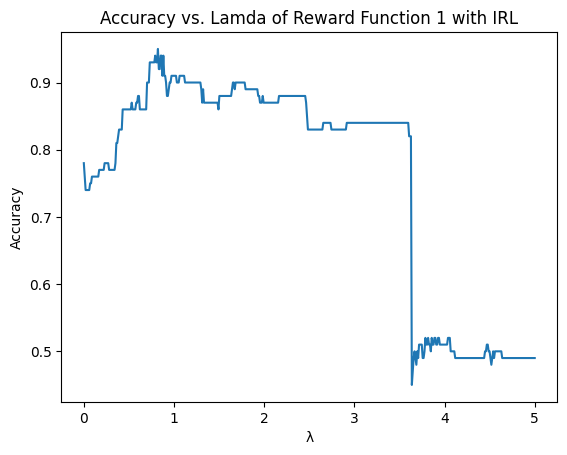

In [22]:
plt.plot(lambdas, accs)

plt.xlabel("λ")
plt.ylabel("Accuracy")

plt.title("Accuracy vs. Lamda of Reward Function 1 with IRL")

Question 11: (30 points) Sweep λ from 0 to 5 to get 500 evenly spaced values for λ.
For each value of λ compute OA(s) by following the process described above. For this
problem, use the optimal policy of the agent found in question 5 to fill in the OE(s)
values. Then use equation 3 to compute the accuracy of the IRL algorithm for this
value of λ. You need to repeat the above process for all 500 values of λ to get 500 data
points. Plot λ (x-axis) against Accuracy (y-axis). In this question, you should have 1 plot.

### QUESTION 12

In [19]:
acc_max_1 = np.max(accs)
lambda_max_1 = lambdas[np.argmax(accs)]

print("Maximum value of lambda  : ",lambda_max_1)
print("Maximum Accuracy         : {:.2f}%".format(acc_max_1*100))

Maximum value of lambda  :  0.8216432865731462
Maximum Accuracy         : 95.00%


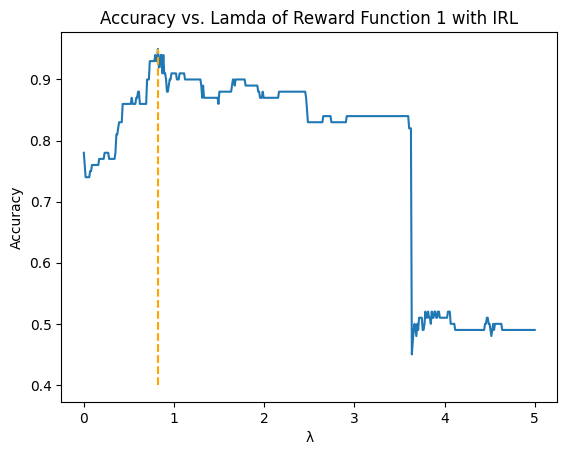

In [21]:
plt.plot(lambdas, accs)

plt.xlabel("λ")
plt.ylabel("Accuracy")

plt.title("Accuracy vs. Lamda of Reward Function 1 with IRL")

plt.vlines(0.8216432865731462, 0.4, 0.95, colors = 'orange', linestyles = 'dashed')

Question 12: (5 points) Use the plot in question 11 to compute the value of λ for which
accuracy is maximum. For future reference we will denote this value as λ
(1)
max. Please
report λ
(1)
max

### QUESTION 13

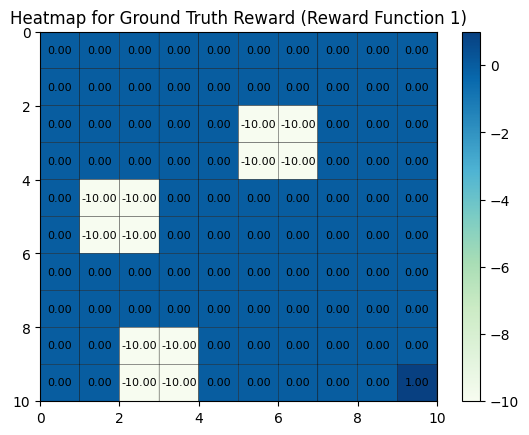

In [25]:
plt.pcolor(reward_function1, cmap='GnBu', edgecolors='black')
plt.title("Heatmap for Ground Truth Reward (Reward Function 1)")

for (j,i),label in np.ndenumerate(reward_function1):
  plt.text(i+0.5, j+0.5, "{:.2f}".format(label), ha='center', va='center', fontsize=8)

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

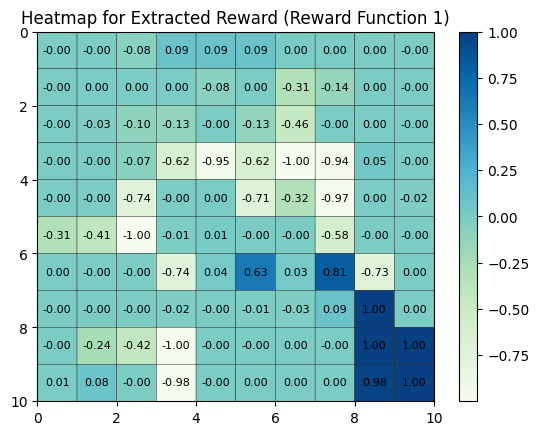

In [26]:
extracted_reward_1 = irl(P_exp, tp, R_max, state_space, act_sets, gamma, lambda_max_1)

plt.pcolor(extracted_reward_1.reshape((10, 10)).T, cmap='GnBu', edgecolors='black')
plt.title("Heatmap for Extracted Reward (Reward Function 1)")

for (j,i),label in np.ndenumerate(extracted_reward_1.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, "{:.2f}".format(label), ha='center', va='center', fontsize=8)

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

Question 13: (15 points) For λ
(1)
max, generate heat maps of the ground truth reward and
the extracted reward. Please note that the ground truth reward is the Reward function
1 and the extracted reward is computed by solving the linear program given by equation
2 with the λ parameter set to λ
(1)
max. In this question, you should have 2 plots.

### QUESTION 14

Number of steps needed to converge: 22



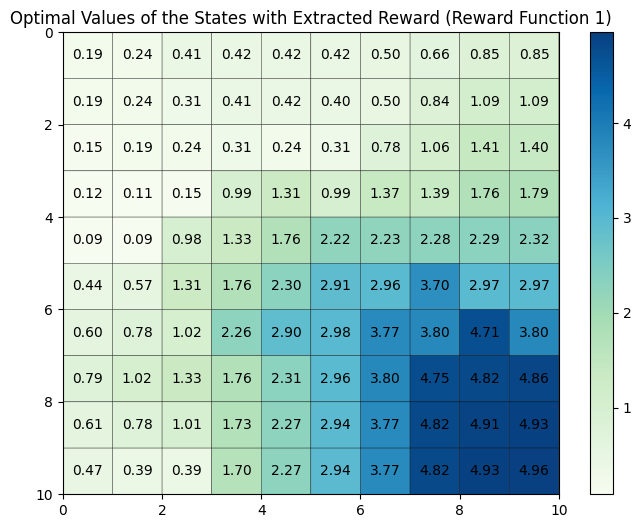

In [27]:
V_agent_1, num_steps_1 = optimal_state_value_function(tp, extracted_reward_1, state_space,
                                                      act_sets, gamma, epsilon)

print("Number of steps needed to converge: {}\n".format(num_steps_1))

plt.figure(figsize=(8, 6))
plt.pcolor(V_agent_1.reshape((10, 10)).T, cmap='GnBu', edgecolors='black')

plt.title("Optimal Values of the States with Extracted Reward (Reward Function 1)")
for (j, i), label in np.ndenumerate(V_agent_1.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

Question 14: (10 points) Use the extracted reward function computed in question 13,
to compute the optimal values of the states in the 2-D grid. For computing the optimal
values you need to use the optimal state-value function that you wrote in question 2. For
visualization purpose, generate a heat map of the optimal state values across the 2-D grid
(similar to the figure generated in question 3). In this question, you should have 1 plot.

### QUESTION 15

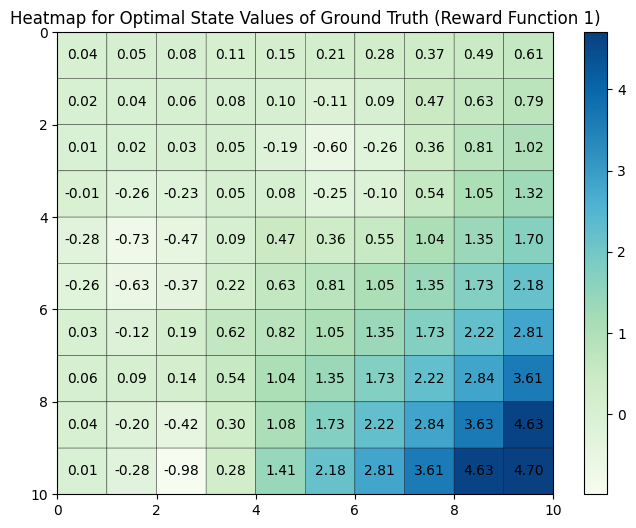

In [28]:
# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_exp.reshape((10, 10)).T, cmap='GnBu', edgecolors='black')
plt.title("Heatmap for Optimal State Values of Ground Truth (Reward Function 1)")

for (j, i), label in np.ndenumerate(V_exp.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

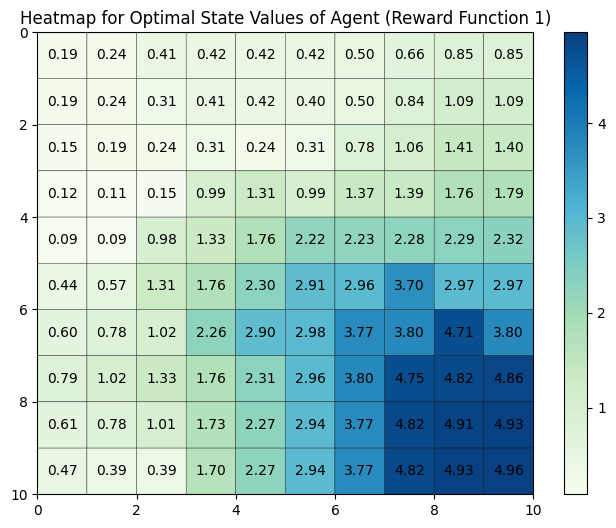

In [29]:
V_agent_1, num_steps_1 = optimal_state_value_function(tp, extracted_reward_1, state_space,
                                                      act_sets, gamma, epsilon)

# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_agent_1.reshape((10, 10)).T, cmap='GnBu', edgecolors='black')
plt.title("Heatmap for Optimal State Values of Agent (Reward Function 1)")

for (j, i), label in np.ndenumerate(V_agent_1.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

Question 15: (10 points) Compare the heat maps of Question 3 and Question 14 and
provide a brief explanation on their similarities and differences.

### QUESTION 16

In [30]:
# plot arrow function
def plot_arrow_diff(P_agent, P_exp, state_space, title):

    diff_idx = np.where(P_agent != P_exp)[0]
    diff_coor = [state_space[i] for i in diff_idx]
    action_matrix = P_agent.reshape((10, 10)).T

    fig, ax = plt.subplots()
    num_rows = len(action_matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = action_matrix[i][j]
            arrow = ''
            if(c == 0):
                arrow = u'→'
            elif(c == 1):
                arrow = u'←'
            elif(c == 2):
                arrow = u'↑'
            else:
                arrow = u'↓'

            if (i, j) in diff_coor:
              ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center', color='red')
            else:
              ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.set_title(title)
    ax.xaxis.tick_top()
    ax.grid()

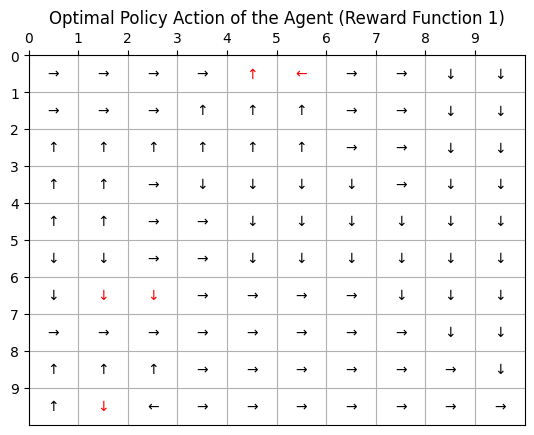

In [31]:
# get optimal policy based on extracted reward
V_agent_1, num_steps_agent_1, P_agent_1 = optimal_policy_function(tp, extracted_reward_1,
                                                                  state_space, act_sets,
                                                                  gamma, epsilon)

# get optimal policy based on GT reward
V_exp_1, num_steps_exp_1, P_exp_1 = optimal_policy_function(tp, reward_function1.flatten("F"),
                                                            state_space, act_sets,
                                                            gamma, epsilon)

# make plot
title = "Optimal Policy Action of the Agent (Reward Function 1)"
plot_arrow_diff(P_agent_1, P_exp_1, state_space, title)

Question 16: (10 points) Use the extracted reward function found in question 13 to
compute the optimal policy of the agent. For computing the optimal policy of the agent
you need to use the function that you wrote in question 5. For visualization purpose, you
should generate a figure similar to that of figure 1 but with the number of state replaced
by the optimal action at that state. The actions should be displayed using arrows. In
this question, you should have 1 plot.

### QUESTION 17

Question 17: (10 points) Compare the figures of Question 5 and Question 16 and provide
a brief explanation on their similarities and differences.

### QUESTION 18

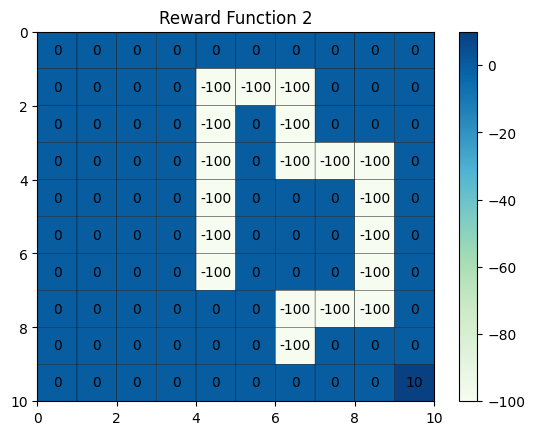

In [34]:
plt.pcolor(reward_function2, cmap='GnBu', edgecolors='black')

plt.title("Reward Function 2")
for (j,i),label in np.ndenumerate(reward_function2):
  plt.text(i+0.5, j+0.5, label, ha='center', va='center')

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [32]:
# Setting up all values from the spec
num_states = 100

state_space = dict()

for i in range(num_states):
  row = i % 10
  col = i // 10
  state_space[i] = (row, col)
num_acts = 4

act_sets = np.array(["right", "left", "up", "down"])

rwd = reward_function2.flatten("F")
R_max = rwd.max()

gamma = 0.8
epsilon = 0.01
w = 0.1

tp = get_tp(w, act_sets, state_space)

In [33]:
# Ground Truth optimal policy from expert [P_opt] based on reward function 2
V_exp, num_steps_exp, P_exp = optimal_policy_function(tp, rwd, state_space,
                                                      act_sets, gamma, epsilon)

In [35]:
'''
Sweep λ from 0 to 5, and compute the IRL accuracy
'''
lambdas = np.linspace(0, 5, 500)
accs = []
for lambda_ in lambdas:
  extracted_rwd = irl(P_exp, tp, R_max, state_space, act_sets, gamma, lambda_)
  V_agent, num_steps_agent, P_agent = optimal_policy_function(tp, extracted_rwd, state_space,
                                                              act_sets, gamma, epsilon)
  accs.append(accuracy(P_exp, P_agent))

Text(0.5, 1.0, 'Accuracy vs. Lamda of Reward Function 2 with IRL')

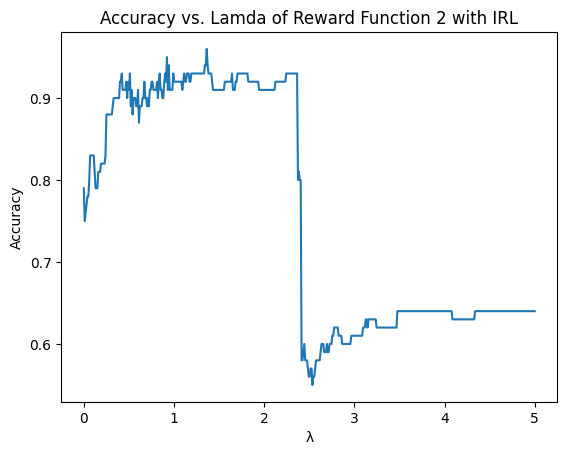

In [36]:
plt.plot(lambdas, accs)

plt.xlabel("λ")
plt.ylabel("Accuracy")

plt.title("Accuracy vs. Lamda of Reward Function 2 with IRL")

Question 18: (30 points) Sweep λ from 0 to 5 to get 500 evenly spaced values for λ.
For each value of λ compute OA(s) by following the process described above. For this
problem, use the optimal policy of the agent found in question 8 to fill in the OE(s)
values. Then use equation 3 to compute the accuracy of the IRL algorithm for this
value of λ. You need to repeat the above process for all 500 values of λ to get 500 data
points. Plot λ (x-axis) against Accuracy (y-axis). In this question, you should have 1 plot.

As seen in the above figure, we have plotted the Accuracy (y- axis) v.s. Lamda (x- axis). The graph suggests a pattern in the relationship between the regularization parameter λ and the accuracy of the inverse reinforcement learning (IRL) algorithm. We make the following observations from the graph:

1. **Increasing Accuracy**: Initially, as λ increases, the accuracy of the IRL algorithm also increases. This is because higher values of λ lead to stronger regularization, which helps in preventing overfitting and improves the generalization of the learned model.

2. **Sharp Dip**: After a certain point, there's a sharp dip in accuracy as λ continues to increase. This dip indicates that too much regularization starts to have a detrimental effect on the accuracy. It suggests that the model is being overly constrained by the regularization term, leading to a loss in performance.

3. **Stable Values**: Following the sharp dip, the accuracy stabilizes and remains relatively constant as λ further increases. This stability suggests that beyond a certain threshold, additional regularization does not significantly impact the accuracy of the IRL algorithm. The model has reached a point where it is sufficiently regularized to avoid overfitting without sacrificing too much accuracy.

The above pattern is expected because Lamda acts as a regularizer (L1 or Lasso normalization), encouraging simpler reward vectors. Finite values of improves robustness, succinctness and transferability of the extracted reward function such that it generalizes well when extracting the optimal policy, which explains the initial rise in accuracy. Large values of will yield reward vectors that underfit the tasks and are not expressive enough to derive the optimal global policy, with increased risk of being stuck in a locally optimum policy.

The above pattern is common when tuning regularization parameters in machine learning models. There's often a trade-off between model complexity (captured by the data fidelity term) and regularization (captured by the regularization term). The goal is to find the right balance that maximizes accuracy while preventing overfitting.


### QUESTION 19

In [37]:
acc_max_2 = np.max(accs)
lambda_max_2 = lambdas[np.argmax(accs)]

print("Maximum value of lambda  : ",lambda_max_2)
print("Maximum Accuracy         : {:.2f}%".format(acc_max_2*100))

Maximum value of lambda  :  1.3627254509018036
Maximum Accuracy         : 96.00%


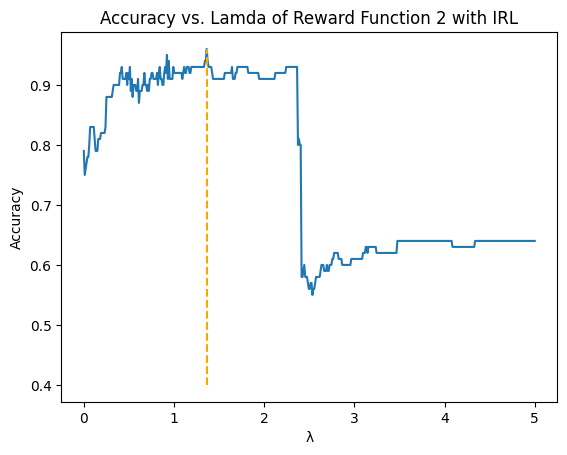

In [39]:
plt.plot(lambdas, accs)

plt.xlabel("λ")
plt.ylabel("Accuracy")

plt.title("Accuracy vs. Lamda of Reward Function 2 with IRL")

plt.vlines(1.3627254509018036, 0.4, 0.96, colors = 'orange', linestyles = 'dashed')

Question 19: (5 points) Use the plot in question 18 to compute the value of λ for which
accuracy is maximum. For future reference we will denote this value as λ
(2)
max. Please
report λ
(2)
max

The above figure shows the plot of Accuracy v.s. Lamda and the orange line marks the maximum value of Accuracy.

Maximum value of lambda  :  1.3627254509018036

Maximum Accuracy         :  0.96

### QUESTION 20

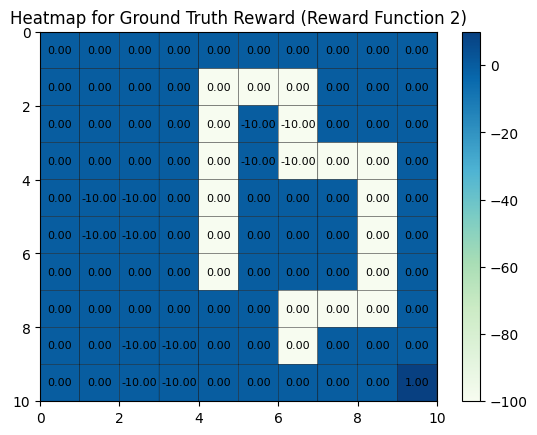

In [40]:
plt.pcolor(reward_function2, cmap='GnBu', edgecolors='black')
plt.title("Heatmap for Ground Truth Reward (Reward Function 2)")

for (j,i),label in np.ndenumerate(reward_function1):
  plt.text(i+0.5, j+0.5, "{:.2f}".format(label), ha='center', va='center', fontsize=8)

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

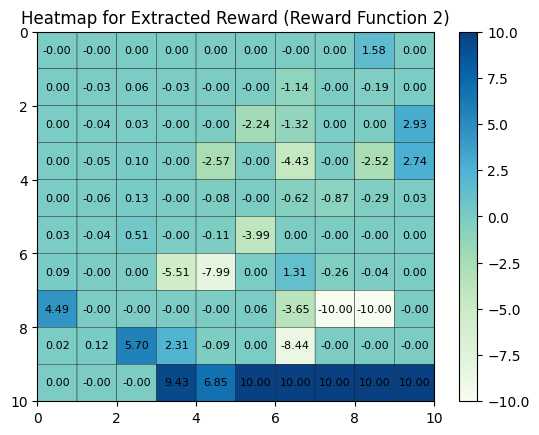

In [41]:
extracted_reward_2 = irl(P_exp, tp, R_max, state_space, act_sets, gamma, lambda_max_2)

plt.pcolor(extracted_reward_2.reshape((10, 10)).T, cmap='GnBu', edgecolors='black')
plt.title("Heatmap for Extracted Reward (Reward Function 2)")

for (j,i),label in np.ndenumerate(extracted_reward_2.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, "{:.2f}".format(label), ha='center', va='center', fontsize=8)

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

Question 20: (15 points) For λ
(2)
max, generate heat maps of the ground truth reward and
the extracted reward. Please note that the ground truth reward is the Reward function
2 and the extracted reward is computed by solving the linear program given by equation
2 with the λ parameter set to λ
(2)
max. In this question, you should have 2 plots.

The above figures illustrate that the rewards extracted by the IRL algorithm exhibit a smoother distribution across the state space compared to the actual reward function. This difference arises because the extracted rewards are derived from the expert policy rather than directly from the ground truth rewards. The expert policy, influenced by optimal values, undergoes gradual changes unlike the discrete nature of the reward function. Consequently, the scales of the extracted and expert reward functions differ.

Furthermore, the IRL algorithm accurately identifies regions surrounding state 99 as having high rewards and the negative-reward chain as having low rewards. In the extracted reward heatmap, as one moves away from state 99, the immediate reward diminishes. Similarly, neighboring states near the negative-reward chain exhibit lower rewards in the extracted reward heatmap compared to those near the highest-reward state. However, a notable difference is the identification of another high-reward region near states 28 and 38, surpassing state 99. This discrepancy arises because the reward function alone doesn't fully indicate long-term returns; thus, learning from the expert policy, which incorporates optimal state values, enhances the algorithm's understanding of the state-space. This learning process offers insights into navigating the state-space effectively, especially when decisions are based on immediate rewards in partially observable environments.



### QUESTION 21

Number of steps needed to converge: 32



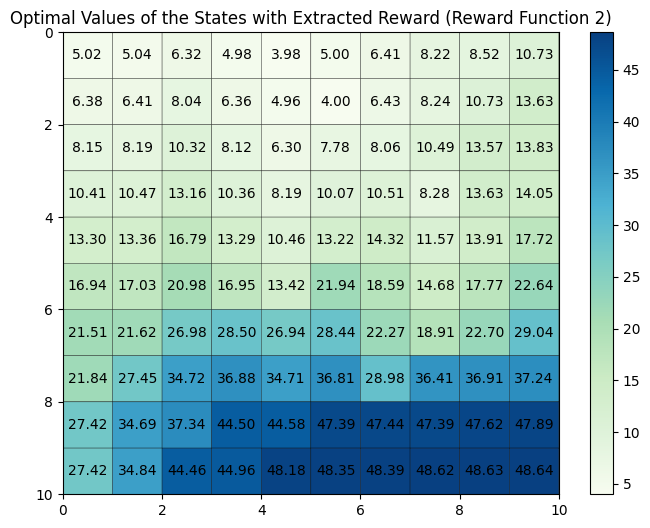

In [42]:
V_agent_2, num_steps_2 = optimal_state_value_function(tp, extracted_reward_2, state_space,
                                                      act_sets, gamma, epsilon)

print("Number of steps needed to converge: {}\n".format(num_steps_2))

plt.figure(figsize=(8, 6))
plt.pcolor(V_agent_2.reshape((10, 10)).T, cmap='GnBu', edgecolors='black')

plt.title("Optimal Values of the States with Extracted Reward (Reward Function 2)")

for (j, i), label in np.ndenumerate(V_agent_2.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

Question 21: (10 points) Use the extracted reward function computed in question 20,
to compute the optimal values of the states in the 2-D grid. For computing the optimal
values you need to use the optimal state-value function that you wrote in question 2. For
visualization purpose, generate a heat map of the optimal state values across the 2-D grid
(similar to the figure generated in question 7). In this question, you should have 1 plot.

The above heatmap shows the optimal state-values from the extracted reward function with using value iteration.

### QUESTION 22

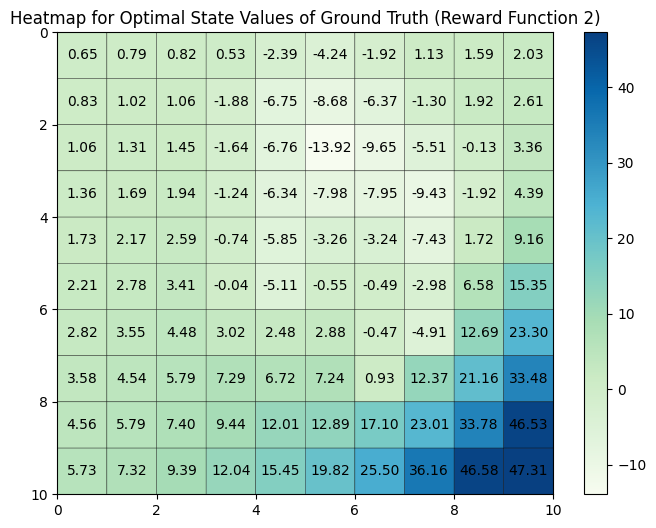

In [43]:
# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_exp.reshape((10, 10)).T, cmap='GnBu', edgecolors='black')
plt.title("Heatmap for Optimal State Values of Ground Truth (Reward Function 2)")

for (j, i), label in np.ndenumerate(V_exp.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

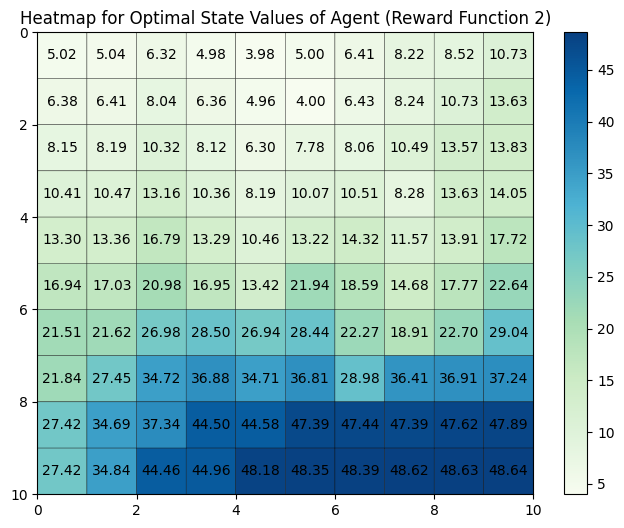

In [45]:
V_agent_2, num_steps_2 = optimal_state_value_function(tp, extracted_reward_2, state_space,
                                                      act_sets, gamma, epsilon)


plt.figure(figsize=(8, 6))
plt.pcolor(V_agent_2.reshape((10, 10)).T, cmap='GnBu', edgecolors='black')
plt.title("Heatmap for Optimal State Values of Agent (Reward Function 2)")

for (j, i), label in np.ndenumerate(V_agent_2.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

Question 22: (10 points) Compare the heat maps of Question 7 and Question 21 and
provide a brief explanation on their similarities and differences.

In this comparison, we're examining the heatmaps from Question 7 and Question 21, focusing on both similarities and differences:

Similarities:

The area with negative rewards (representing the lowest optimal values) is roughly consistent and located similarly in both heatmaps.
Proximity to state 99 corresponds to high optimal values in both plots, although it's not the highest in one of them. State 99 yields the highest reward, causing values to gradually decrease as one moves away from it in both plots.
When we observe the heatmaps from both plots, we can notice a gradual change in optimal values as the agent navigates through different states. As the agent moves towards states with low rewards, the neighboring states exhibit a progressive decrease in optimal values. Conversely, when the agent heads towards states with higher rewards, the optimal values of surrounding states gradually increase. This trend occurs because of the discount factor incorporated into the Bellman equation. This factor essentially downgrades the significance of future rewards, influencing the agent's decision-making process. Consequently, the observed gradual decay or increase in optimal values around states with low or high rewards respectively illustrates how the agent strategically adapts its actions to maximize long-term cumulative rewards while considering the discounted nature of future rewards. While this phenomenon is evident in both plots, it appears more prominently in Question 21 due to the specific characteristics of the extracted reward function.

Differences:

In Question 21's heatmap, we notice a shift in the distribution of optimal values compared to the region near state 99. Although state 99 still exhibits high optimal values, it's not the highest in this case. Instead, the highest optimal values are now found in the lower-left corner of the state-space. This change is attributed to the limitations of relying solely on the reward function as an indicator of long-term expected return. While the reward function provides valuable information, it's essential to complement it with insights from the transition matrix and optimal state values. In the context of Inverse Reinforcement Learning (IRL), which learns the reward function from expert policies, this integration of various factors allows for a more nuanced understanding of the state-space. By learning from expert policies, which encapsulate optimal expert state values, the IRL algorithm gains valuable heuristics about the state-space beyond what traditional value iteration methods offer. One significant advantage of learning from policy is that it provides the agent with richer information about the state-space concerning rewards. For instance, as the agent approaches state 99, it observes higher rewards, contributing to a gradual increase in reward. This gradual change in reward as the agent navigates towards "key states" with very high or low rewards enables the agent to formulate more effective policies, especially in scenarios where the state-space is only partially observable, and decisions must be made based on immediate rewards. In essence, this feedback loop, where the agent gains insights from gradually changing immediate rewards at each state, equips it with valuable heuristics about which direction to move towards, enhancing its decision-making process, particularly in complex and partially observable environments.

The difference in scaling between the heatmaps from Question 7 and Question 21 can be attributed to the methodology used to generate them. In Question 7, the heatmap is derived directly from the ground truth reward function. This means that the values in the heatmap represent the actual rewards associated with each state in the environment. Since the ground truth reward function provides a direct measure of rewards, the range of optimal state values in the heatmap corresponds directly to the range of rewards specified in the reward function. In contrast, in Question 21, the heatmap is generated from the extracted reward, which is calculated based on the expert policy rather than the expert reward. This means that the values in the heatmap reflect the optimal values obtained from the expert policy, which may not necessarily align perfectly with the rewards specified in the ground truth reward function. Consequently, the range or scale of optimal state values in the heatmap from Question 21 may differ from that of Question 7. The scaling difference arises because the extracted reward is influenced by the expert policy's decisions, which could lead to variations in the range of optimal state values compared to the ground truth reward function. Therefore, while both heatmaps represent optimal values, the source of the data (ground truth reward function versus extracted reward from expert policy) can result in different scaling characteristics between the two heatmaps.

In Question 7, the heatmap is derived directly from the ground truth reward function, which typically assigns 0 reward to most states, except for specific regions like the negative-reward snake-like chain and perhaps a single high-reward state. As a result, the regions in the heatmap from Question 7 are well-defined and homogeneous, with clear boundaries between areas of different reward values. This is because the ground truth reward function provides a clear and discrete assignment of rewards to states. On the other hand, in Question 21, the heatmap is generated from the extracted reward, which is influenced by the decisions of the expert policy rather than the direct rewards specified in the ground truth reward function. As seen in the reward vector heatmap plots from Question 20, where immediate rewards are assigned to all states, the extracted reward tends to be more continuous and spread out across the state space. This means that most states have nonzero rewards, contributing to a more continuous distribution of optimal values in the heatmap from Question 21. Therefore, the differences in homogeneity and definition between the two heatmaps stem from the source of the reward information used to generate them. The ground truth reward function results in well-defined regions with discrete reward values, while the extracted reward from the expert policy leads to a more continuous and spread-out distribution of rewards, influencing the homogeneity and definition of regions within the heatmap.

In Question 7, where the heatmap is derived from the ground truth reward function, the agent faces a more stringent penalty near regions with lower rewards. This means that the agent is discouraged from moving towards states with lower rewards, as the lower immediate rewards and harsh penalties associated with those regions push the agent away from them. Consequently, the agent is more inclined to seek out optimal regions where the long-term expected reward is maximized. However, in Question 21, where the heatmap is generated from the extracted reward based on the expert policy, the penalties near regions with lower rewards are less severe compared to Question 7. This means that the agent is not as strongly discouraged from exploring states with lower immediate rewards, as the penalties are milder. As a result, there's a higher probability for the agent to remain in or move towards these suboptimal regions, where immediate and local rewards might seem attractive but ultimately lead to a lower long-term expected reward. In essence, the differences in how the agent is penalized near regions with lower rewards between Question 21 and Question 7 influence the agent's decision-making process. In Question 21, the agent is more likely to be lured away from optimal regions by the allure of immediate rewards, leading to a lower expected reward in the long run compared to the agent in Question 7. This difference underscores the importance of understanding how different reward structures can impact an agent's behavior and ultimately its performance in a given environment.


### QUESTION 23

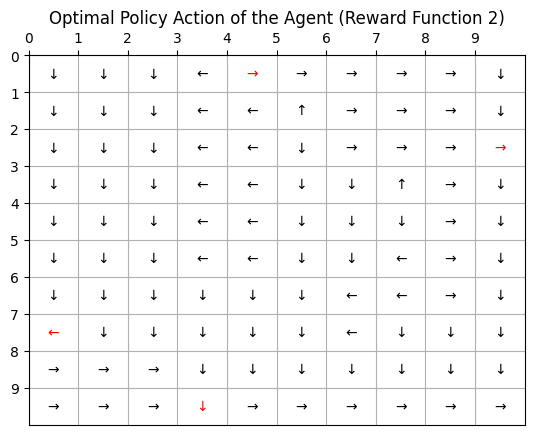

In [47]:
# Optimal policy based on extracted reward
V_agent_2, num_steps_agent_2, P_agent_2 = optimal_policy_function(tp, extracted_reward_2,
                                                                  state_space, act_sets,
                                                                  gamma, epsilon)

# Optimal policy based on Ground Truth reward
V_exp_2, num_steps_exp_2, P_exp_2 = optimal_policy_function(tp, reward_function2.flatten("F"),
                                                            state_space, act_sets,
                                                            gamma, epsilon)

title = "Optimal Policy Action of the Agent (Reward Function 2)"
plot_arrow_diff(P_agent_2, P_exp_2, state_space, title)

Question 23: (10 points) Use the extracted reward function found in question 20 to
compute the optimal policy of the agent. For computing the optimal policy of the agent
you need to use the function that you wrote in question 9. For visualization purpose, you
should generate a figure similar to that of figure 1 but with the number of state replaced
by the optimal action at that state. The actions should be displayed using arrows. In
this question, you should have 1 plot.

Comparison between the action plots in Question 9 and Question 23, identifying both similarities and differences:

Similarities:
In both scenarios, the agent demonstrates a tendency to navigate away from areas characterized by low rewards or suboptimal values, while aiming to approach regions associated with high rewards or optimal values.

Divergence of some arrows, indicating movement away from each other, is observed in both cases. This phenomenon may arise from encountering incompatible states or conditions within the environment.

Actions are distributed evenly across all four cardinal directions (up, down, left, and right) in both plots. This implies that the agent employs a strategy of exploring all possible directions to reach optimal states efficiently.

Differences:

In Question 23, compared to Question 9, we observe the presence of two distinct high-reward regions, as indicated by the convergence of arrows towards these areas. This contrast arises because the Inverse Reinforcement Learning (IRL) algorithm, utilized in Question 23, identifies an additional high-reward region located in the lower left corner around states 28 and 38. This finding is consistent with the insights obtained from both Question 20 and Question 22. The identification of this additional high-reward region underscores the limitations of relying solely on the reward function as an indicator of long-term expected return. Instead, it emphasizes the importance of integrating information from the transition matrix and optimal state values alongside the reward function. In the context of IRL, the algorithm learns the reward function from expert policies, which in turn reflect optimal expert state values. This learning process equips the IRL algorithm with enhanced insights and heuristics about the state-space compared to conventional value iteration methods. In summary, the presence of two high-reward regions in Question 23, as opposed to one in Question 9, highlights the IRL algorithm's ability to discern nuanced patterns within the state-space, ultimately leading to a more comprehensive understanding of optimal regions and improved decision-making capabilities.

In Question 23, there are instances where certain actions may lead the agent to move off the grid, a scenario not observed for the agent in Question 9. This difference arises due to the nature of the state-space in Question 21, which influences the agent's decision-making process differently compared to Question 7. In Question 21, where the state-space is influenced by the extracted reward based on the expert policy, the agent faces a higher probability of not moving towards optimal regions. This is because immediate and local rewards can sometimes lure the agent towards suboptimal directions, overshadowing the consideration of the maximum achievable long-term reward. Consequently, the agent may accumulate a lower expected reward over time in Question 21 compared to Question 7. This discrepancy in expected reward between the two scenarios can lead to a higher likelihood of the agent moving off the grid or taking suboptimal actions in the long run, particularly evident in Question 23. The agent's decision-making process in Question 23 may be influenced by the allure of immediate rewards, causing it to deviate from optimal paths or even venture beyond the boundaries of the grid. Overall, the difference in the state-space characteristics between Question 21 and Question 7 impacts the agent's behavior and decision-making strategy, ultimately influencing its long-term performance and propensity to stray from optimal trajectories, particularly noticeable in the actions taken in Question 23.

In Question 23, we observe that some actions point towards each other, indicating local optima in the policy plots. This phenomenon results in what's known as a deadlock condition, where the agent continually oscillates between two states without making progress. This occurrence arises due to the gradual changes in immediate rewards among neighboring states. When the immediate rewards between two neighboring states are very similar and non-zero, the agent becomes trapped in a cycle of moving back and forth between these states, especially if the exploration probability is low. This deadlock condition is absent in the policy map of Question 9 because most rewards in the state space are zero. This absence of nonzero rewards enhances the agent's foresight, allowing it to propagate the influence of high-reward states to neighboring states much more effectively than in Question 23. In essence, the values in the state-space of Question 9 exhibit less noise compared to Question 23. This reduced noise enables the agent in Question 9 to discern the correct direction from a further distance, avoiding the trap of oscillating between states. Consequently, the absence of deadlock conditions in Question 9 enhances the efficiency of the agent's decision-making process and its ability to navigate towards optimal states more effectively.

In Question 9, where most rewards are zero, the agent can reliably reach the optimal state from any starting point due to clear decision-making signals. However, in Question 23, the presence of non-zero rewards introduces uncertainty. This increases the risk of the agent being led off the grid or getting stuck in suboptimal paths, making it less certain to reach the optimal state from any starting point.

In Question 9, where most rewards are zero, the agent's actions are ordered and directed towards the optimal state in a predictable manner. However, in Question 23, the presence of non-zero rewards introduces variability and randomness into the agent's actions, leading to a less deterministic path towards the optimal state.


### QUESTION 24

Question 24: (10 points) Compare the figures of Question 9 and Question 23 and provide
a brief explanation on their similarities and differences.

### QUESTION 25

Question 25: (50 points) From the figure in question 23, you should observe that the
optimal policy of the agent has two major discrepancies. Please identify and provide the
causes for these two discrepancies. One of the discrepancy can be fixed easily by a slight
modification to the value iteration algorithm. Perform this modification and re-run the
modified value iteration algorithm to compute the optimal policy of the agent. Also,
recompute the maximum accuracy after this modification. Is there a change in maximum
accuracy? The second discrepancy is harder to fix and is a limitation of the simple IRL
algorithm.

In [48]:
# edit the value iteration algorithm
def value_iteration_Q25(tp, rwd, state_space, actions, gamma, epsilon):
  Vs = np.zeros(len(state_space))
  delta = np.inf
  num_steps = 0
  old_Vs = np.copy(Vs)
  policy = np.zeros(100)

  while delta > epsilon:
    delta = 0
    for i in range(len(state_space)):
      Vs[i] = max([np.sum(tp[act][i]*(rwd + gamma*old_Vs)) for act in actions])
      delta = max(delta, abs(old_Vs[i] - Vs[i]))
    old_Vs = np.copy(Vs)
    num_steps += 1

  for i in range(len(state_space)):
    temp = [np.sum(tp[act][i]*(rwd + gamma*Vs)) for act in actions]

    # convert the state value that goes off the grid to '-np.inf' to constrain going off the grid
    if i != 99:
      if i >= 90:
        temp[0] = -np.inf  # right edge
      if i <= 9:
        temp[1] = -np.inf  # left edge
      if i%10 == 0:
        temp[2] = -np.inf  # top edge
      if i%10 == 9:
        temp[3] = -np.inf  # bottom edge
    ###########################################################################################

    policy[i] = np.argmax(temp)

  return Vs, num_steps, policy

The new accuracy based on new value iteration algorithm: 98.00%



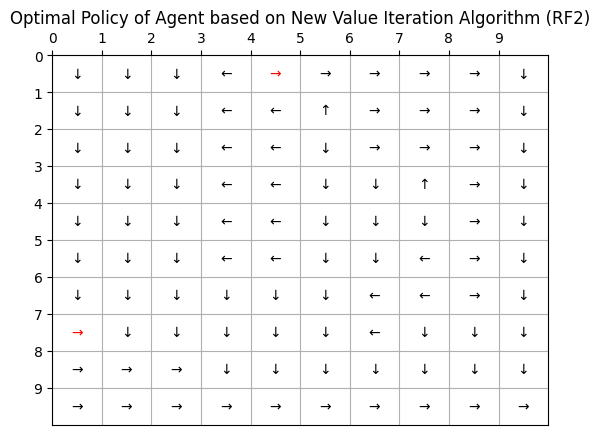

In [50]:
extracted_rwd_Q25 = irl(P_exp, tp, R_max, state_space, act_sets, gamma, lambda_max_2)

# get new optimal policy based on extracted rewar
V_agent_Q25, num_steps_agent_Q25, P_agent_Q25 = value_iteration_Q25(tp, extracted_reward_2,
                                                                    state_space, act_sets,
                                                                    gamma, epsilon)

# # get optimal policy based on GT reward
# V_exp_2, num_steps_exp_2, P_exp_2 = optimal_policy_function(tp, rwd_f2.flatten("F"),
#                                                             state_space, act_sets,
#                                                             gamma, epsilon)
acc_Q25 = accuracy(P_exp_2, P_agent_Q25)
print("The new accuracy based on new value iteration algorithm: {:.2f}%\n".format(acc_Q25*100))

# make plot
title = "Optimal Policy of Agent based on New Value Iteration Algorithm (RF2)"
plot_arrow_diff(P_agent_Q25, P_exp_2, state_space, title)

In [51]:
def irl(P_exp, tp, rwd, state_space, act_sets, gamma, lambda_):
  # parameter
  num_states = len(state_space)
  num_acts = len(act_sets)
  R_max = rwd.max()

  # init
  I = np.identity(num_states)
  P_all = np.zeros(((num_acts-1)*num_states, num_states))
  iden_mat = np.zeros(((num_acts-1)*num_states, num_states))
  j = 0

  # get c, D, b matrices
  for i in range(len(P_exp)):
    policy_direction = act_sets[int(P_exp[i])]
    for action in act_sets:
      if (policy_direction == action):
        continue
      P_a1 = tp[policy_direction]
      P_a = tp[action]
      P_all[j, :] = np.matmul((P_a[i] - P_a1[i]).reshape(1, 100),
                              np.linalg.inv(I - gamma*P_a1))
      iden_mat[j, i] = 1
      j += 1

  D = np.vstack((np.hstack((iden_mat, P_all, np.zeros(P_all.shape))),
                 np.hstack((np.zeros(P_all.shape), P_all, np.zeros(P_all.shape))),
                 np.hstack((np.zeros(I.shape), np.identity(num_states), -np.identity(num_states))),
                 np.hstack((np.zeros(I.shape), -np.identity(num_states), -np.identity(num_states))),
                 np.hstack((np.zeros(I.shape), np.identity(num_states), np.zeros(I.shape))),
                 np.hstack((np.zeros(I.shape), -np.identity(num_states), np.zeros(I.shape)))))

  b = np.vstack((np.zeros((P_all.shape[0], 1)),
                 np.zeros((P_all.shape[0], 1)),
                 np.zeros((num_states, 1)),
                 np.zeros((num_states, 1)),
                 R_max*np.ones((num_states, 1)),
                 R_max*np.ones((num_states, 1))))

  c = np.vstack((np.ones((num_states, 1)),
                 np.zeros((num_states, 1)),
                 -lambda_*np.ones((num_states, 1))))

  # solve x and get predicted R
  solvers.options['show_progress']=False
  sol = solvers.lp(-matrix(c), matrix(D), matrix(b))
  # R = np.array(sol['x'][100:200])
  R = np.array(sol['x'][-100:]).squeeze()

  return R

The first discrepancy one can observe is that the policy of some states at the edges or corner is moving off the grid instead of following the flow pointed toward the positive reward direction. This is because the way we designed the transition probability as well as the value iteration function might potentially mislead those states to prefer to take the policy that will let them stay in the their current state because of a higher probability even though the optimal state value of that state itself is lower than it's neighboring nodes.

The second discrepancy is the confusion of the correct policy, leading the agent to go toward the wrong or even opposite direction. This occurs because these states are influenced by local rewards that we extracted through IRL algorithm, which can accumulate rapidly in the incorrect direction and overshadow the potential maximum reward, making the agent to be confused about the correct direction.


In the above figure, the presence of non-zero rewards in the state-space of Question 21 introduces complexity into the agent's decision-making process. Unlike in Question 7, where most rewards are zero and the agent can easily discern optimal paths, the varied rewards in Question 21 may lead the agent astray. Immediate rewards that seem attractive may lure the agent off the grid, especially if they overpower the long-term rewards associated with optimal paths. Consequently, the agent may deviate from the intended trajectory, potentially leading to suboptimal outcomes.

In the above figure, certain actions point towards each other, indicating the presence of local optima in the policy plot. This phenomenon creates a deadlock condition where the agent becomes trapped in a loop, oscillating between two states indefinitely. The root cause of this situation lies in the gradual changes in immediate rewards among neighboring states. If the rewards between two neighboring states are similar and non-zero, the agent may struggle to determine the best course of action. With a low exploration probability, the agent may become stuck in a cycle of moving back and forth between these states, unable to progress towards the optimal solution.

To fix the first discrepancy, I basically modify and set up a border constraint for all states at the edges or corner, besides state 99, in the value iteration algorithm by replacing the value to negative infinity so that the action, which causes the agent moving off the grid, is basically eliminated and could not be able to choose as the optimal policy at the end. With such modification, two incorrect arrows / policies have been fixed and the mamaximum accuracy increase from 96% to 98%.
